In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
# import plotly_express as px
# import plotly.graph_objects as go
from unidecode import unidecode
import os
from datetime import date
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

Taux de doublons : 3.84%
full_2017.csv
      code_commune  nb_mutations
0            01001            19
1            01002            33
2            01004           408
3            01005            43
4            01007           105
...            ...           ...
31184        97420           135
31185        97421            20
31186        97422           600
31187        97423            68
31188        97424            52

[31189 rows x 2 columns]
Taux de doublons : 3.57%
full_2018.csv
      code_commune  nb_mutations
0            01001            56
1            01002            77
2            01004          1185
3            01005           213
4            01006            13
...            ...           ...
33070        97420           389
33071        97421            94
33072        97422          1847
33073        97423           171
33074        97424           168

[33075 rows x 2 columns]
Taux de doublons : 3.9%
full_2019.csv
      code_commune  nb_mutations
0      

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2017-1,2017-07-04,000001,Vente,166100.0,843,NaN,RUE DE LA CHARPINE,0100,01000,01344,Saint-Denis-lès-Bourg,01,NaN,NaN,01344000AK0534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,73.0,4.0,S,sols,NaN,NaN,391.0,5.204386,46.193683
1,2017-2,2017-07-06,000001,Vente,59000.0,2,NaN,RUE GOUNOD,1720,01000,01053,Bourg-en-Bresse,01,NaN,NaN,01053000AL0175,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,5.219932,46.196098
2,2017-2,2017-07-06,000001,Vente,59000.0,2,NaN,RUE GOUNOD,1720,01000,01053,Bourg-en-Bresse,01,NaN,NaN,01053000AL0175,NaN,NaN,45,32.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,32.0,1.0,NaN,NaN,NaN,NaN,NaN,5.219932,46.196098
3,2017-3,2017-07-07,000001,Vente terrain à bâtir,55000.0,NaN,NaN,LA MAGDELEINE,B033,01160,01430,Varambon,01,NaN,NaN,014300000B0831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,605.0,5.304674,46.040624
4,2017-4,2017-07-06,000001,Vente,130000.0,NaN,NaN,HAMEAU DU CREUX EST,B148,01750,01320,Replonges,01,NaN,NaN,013200000D4182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AG,terrains d'agrément,NaN,NaN,259.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429088,2022-537271,2022-06-21,000001,Vente,423000.0,43,NaN,RUE DES FAVORITES,3536,75015,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000AC0055,NaN,NaN,16,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.305379,48.837454
1429089,2022-537271,2022-06-21,000001,Vente,423000.0,43,NaN,RUE DES FAVORITES,3536,75015,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000AC0055,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.305379,48.837454
1429090,2022-537272,2022-06-30,000001,Vente,104650.0,50,NaN,RUE LEON FROT,5554,75011,75111,Paris 11e Arrondissement,75,NaN,NaN,75111000BS0234,NaN,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,15.0,1.0,NaN,NaN,NaN,NaN,NaN,2.386354,48.856079
1429091,2022-537273,2022-02-10,000001,Adjudication,51000.0,12,NaN,SQ HENRY PATE,4608,75016,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000BY0016,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.271505,48.849026


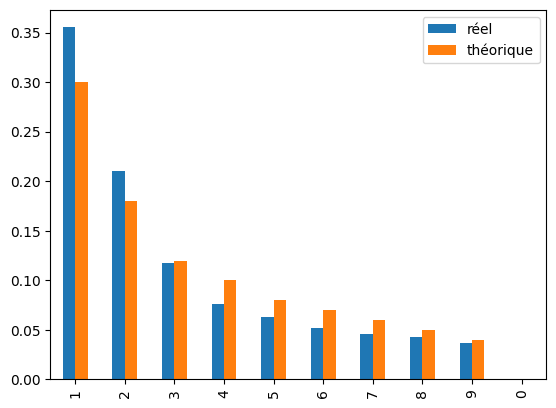

In [4]:
df = pd.DataFrame(None)
dups = {}
nbs_mutations = {}
for f in [k for k in os.listdir() if 'full_' in k]:
    _ = pd.read_csv(f,
                    sep=',', 
                    encoding= 'utf8',
                    dtype=str,
                   )
    len_brute = len(_)
    dups[f] = _.loc[_.duplicated()]
    _ = _.drop_duplicates()
    print(f'Taux de doublons : {round(100*(1-len(_)/len_brute), 2)}%') ## 4% de doublons par an
    df= pd.concat([df, _])
    nbs_mutations[f] = df.groupby('code_commune').size().reset_index().rename({0: 'nb_mutations'}, axis=1)
    print(f)
    print(nbs_mutations[f])
# Benford
benford = df['valeur_fonciere'].str.slice(0,1).value_counts(dropna=True).map(int)
benford /= sum(benford)
theorie = [0.30, 0.18, 0.12, 0.10, 0.08, 0.07, 0.06, 0.05, 0.04, 0]
theorie = pd.Series(theorie, index=benford.index)
df_benford = pd.concat([benford, theorie], axis=1)
df_benford.columns = ['réel', 'théorique']
df_benford.plot.bar()
to_cast = [
    'valeur_fonciere',
    'nombre_pieces_principales',
    'longitude',
    'latitude',
] + [c for c in df.columns if 'surface_' in c]
df.loc[:, to_cast] = df.loc[:, to_cast].astype(float)
df

In [6]:
## import des géométries EPCI
apparts_all = pd.read_csv(r'C:\Users\Dinum\Documents\Projets\Loyers\work\pred-app-mef-dhup.csv', dtype='str', encoding='ISO8859', sep=';', usecols=['INSEE_C', 'EPCI'])
communes = gpd.read_file(r'C:\Users\Dinum\Documents\Projets\Loyers\work\cadastre-france-communes.json')
communes = communes.drop(['created', 'updated'], axis=1)
epci = gpd.GeoDataFrame(communes.loc[~(communes['id'].str.startswith('97'))].merge(apparts_all[['INSEE_C', 'EPCI']], left_on='id', right_on='INSEE_C', how='left').drop(['id', 'INSEE_C'], axis=1))
epci = epci.dissolve('EPCI').reset_index()
epci2commune = apparts_all[['INSEE_C', 'EPCI']].drop_duplicates()

### Doublons et géographie

In [12]:
for f in nbs_mutations.keys():
    nbs_mutations[f] = pd.merge(nbs_mutations[f], epci2commune, left_on='code_commune', right_on='INSEE_C', how='right')
    nbs_mutations[f] = nbs_mutations[f].drop('code_commune', axis=1).fillna(0)
nbs_mut_epci = {k: df.groupby('EPCI')['nb_mutations'].sum().reset_index() for (k,df) in nbs_mutations.items()}
nbs_mut_epci

{'full_2017.csv':            EPCI  nb_mutations
 0     200000172         989.0
 1     200000438         916.0
 2     200000545         416.0
 3     200000628         481.0
 4     200000800         390.0
 ...         ...           ...
 1246  249740085         984.0
 1247  249740093         646.0
 1248  249740101        2533.0
 1249  249740119        2441.0
 1250  ZZZZZZZZZ         346.0
 
 [1251 rows x 2 columns],
 'full_2018.csv':            EPCI  nb_mutations
 0     200000172        2794.0
 1     200000438        2841.0
 2     200000545        1183.0
 3     200000628        1486.0
 4     200000800        1129.0
 ...         ...           ...
 1246  249740085        2966.0
 1247  249740093        2072.0
 1248  249740101        6726.0
 1249  249740119        6493.0
 1250  ZZZZZZZZZ        1011.0
 
 [1251 rows x 2 columns],
 'full_2019.csv':            EPCI  nb_mutations
 0     200000172        4806.0
 1     200000438        5018.0
 2     200000545        2160.0
 3     200000628        2

In [75]:
dups_restr = {file: pd.merge(dups[file][['id_mutation', 'date_mutation', 'code_commune']],
                       epci2commune,
                       left_on='code_commune',
                       right_on='INSEE_C',
                       how='left')['EPCI'].value_counts().reset_index().rename({'index':'EPCI', 'EPCI':'count_dups'}, axis=1) for file in dups.keys()}
dups_restr = {file: pd.merge(dups_restr[file],
                       nbs_mut_epci[file],
                       on='EPCI',
                       how='right') for file in dups.keys()}
for f in dups_restr:
    dups_restr[f]['proportion_dup'] = (dups_restr[f]['count_dups']/(dups_restr[f]['nb_mutations']))*100

count_dups_epci = {file: gpd.GeoDataFrame(pd.merge(dups_restr[file],
                                 epci,
                                 on='EPCI',
                                 how='right').fillna(0)) for file in dups_restr.keys()}

## handling outliers and first/last years (only one semester) compared to other years
max_count = 1000
for file in count_dups_epci.keys():
    count_dups_epci[file]['maxed'] = count_dups_epci[file]['count_dups'].apply(lambda x: min(x,max_count) if any(['2017' in file, '2022' in file]) else min(x/2,max_count)).fillna(0)

In [80]:
count_dups_epci['full_2020.csv'].sort_values(by='proportion_dup')

,EPCI,count_dups,nb_mutations,proportion_dup,geometry,nom,maxed
943,244000774,0.0,2503.0,0.000000,"POLYGON ((-0.32118 43.81199, -0.32151 43.81209...",SAINTE FOY,0.0
1097,246800676,0.0,0.0,0.000000,"POLYGON ((7.01309 47.82220, 7.01339 47.82227, ...",BURNHAUPT-LE-BAS,0.0
1098,246800726,0.0,0.0,0.000000,"POLYGON ((7.34060 48.00377, 7.34054 48.00384, ...",ANDOLSHEIM,0.0
1026,245701206,0.0,0.0,0.000000,"POLYGON ((6.43297 48.78912, 6.43297 48.78905, ...",ACHAIN,0.0
81,200034635,0.0,0.0,0.000000,"POLYGON ((7.58637 48.59037, 7.58637 48.59034, ...",BERSTETT,0.0
...,...,...,...,...,...,...,...
419,200068047,678.0,7096.0,9.554679,"POLYGON ((2.42292 49.21363, 2.42289 49.21359, ...",CRAMOISY,339.0
1045,246000749,358.0,3084.0,11.608301,"POLYGON ((2.99846 49.33781, 2.99740 49.33684, ...",ATTICHY,179.0
1048,246000772,640.0,4093.0,15.636452,"POLYGON ((2.87427 49.46147, 2.87405 49.46127, ...",BAILLY,320.0
158,200040392,4301.0,23863.0,18.023719,"POLYGON ((0.67708 44.95588, 0.67708 44.95584, ...",ANTONNE ET TRIGONANT,1000.0


In [64]:
count_dups_epci['full_2017.csv'].loc[count_dups_epci['full_2017.csv']['count_dups']>count_dups_epci['full_2017.csv']['nb_mutations']]

,EPCI,count_dups,nb_mutations,proportion_dup,geometry,nom
565,200070720,4338.0,3132.0,58.072289,"MULTIPOLYGON (((-1.07968 44.91052, -1.08020 44...",CARCANS


In [24]:
epci2commune.loc[epci2commune['EPCI']=='200070720']['INSEE_C'].to_list()

['33193',
 '33544',
 '33521',
 '33514',
 '33300',
 '33490',
 '33540',
 '33541',
 '33203',
 '33097',
 '33214',
 '33538',
 '33208',
 '33348']

In [25]:
dups['full_2017.csv'].loc[dups['full_2017.csv']['code_commune'].isin(epci2commune.loc[epci2commune['EPCI']=='200070720']['INSEE_C'].to_list())]

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
529722,2017-214001,2017-11-14,000001,Vente,390000,29,NaN,AV DE L EUROPE,0542,33680,33214,Lacanau,33,NaN,NaN,33214000BE0311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,Dépendance,NaN,0,S,sols,NaN,NaN,895,-1.193839,45.002384
529724,2017-214001,2017-11-14,000001,Vente,390000,29,NaN,AV DE L EUROPE,0542,33680,33214,Lacanau,33,NaN,NaN,33214000BE0311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,52,3,S,sols,NaN,NaN,895,-1.193839,45.002384
578591,2017-234708,2017-07-24,000001,Vente,70000,8,NaN,RTE DE SOULAC,0371,33930,33540,Vendays-Montalivet,33,NaN,NaN,33540000BC0728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,60,2,S,sols,NaN,NaN,903,-1.063584,45.357078
578852,2017-234804,2017-08-18,000001,Vente,978000,9005,NaN,PAS DE FORMOSE,0104,33780,33514,Soulac-sur-Mer,33,NaN,NaN,33514000BH0219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,20,3,S,sols,NaN,NaN,3000,-1.126605,45.486985
578853,2017-234804,2017-08-18,000001,Vente,978000,9005,NaN,PAS DE FORMOSE,0104,33780,33514,Soulac-sur-Mer,33,NaN,NaN,33514000BH0219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,20,3,S,sols,NaN,NaN,3000,-1.126605,45.486985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586784,2017-235684,2017-12-29,000001,Vente,3164051.2,7,NaN,RUE JOSEPH LAHENS,0203,33780,33514,Soulac-sur-Mer,33,NaN,NaN,33514000AH0022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,33,2,S,sols,NaN,NaN,3036,-1.12344,45.512618
586785,2017-235684,2017-12-29,000001,Vente,3164051.2,7,NaN,RUE JOSEPH LAHENS,0203,33780,33514,Soulac-sur-Mer,33,NaN,NaN,33514000AH0022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,33,2,S,sols,NaN,NaN,3036,-1.12344,45.512618
586786,2017-235684,2017-12-29,000001,Vente,3164051.2,7,NaN,RUE JOSEPH LAHENS,0203,33780,33514,Soulac-sur-Mer,33,NaN,NaN,33514000AH0022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,34,2,S,sols,NaN,NaN,3036,-1.12344,45.512618
586787,2017-235684,2017-12-29,000001,Vente,3164051.2,7,NaN,RUE JOSEPH LAHENS,0203,33780,33514,Soulac-sur-Mer,33,NaN,NaN,33514000AH0022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,33,2,S,sols,NaN,NaN,3036,-1.12344,45.512618


In [81]:
## étude d'un cas spécifique qui pose problème
_ = pd.read_csv('full_2017.csv',
                sep=',', 
                encoding= 'utf8',
                dtype=str,
               )
restr = _.loc[_['code_commune'].isin(epci2commune.loc[epci2commune['EPCI']=='200070720']['INSEE_C'].to_list())]
restr.groupby('code_commune').size()

code_commune
33097     245
33193    5519
33203     190
33208      77
33214     470
33300     110
33348      72
33490      95
33514     255
33521      31
33538      46
33540     206
33541      69
33544      85
dtype: int64

In [53]:
_.loc[_['id_mutation']=='2017-234818']

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
578932,2017-234818,2017-07-27,000001,Vente,79000,342,U,EURONAT CENTRE DE LOISIRS,A030,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AA0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,47,3,B,bois,NaN,NaN,59702,-1.14846,45.417497
578933,2017-234818,2017-07-27,000001,Vente,79000,342,U,EURONAT CENTRE DE LOISIRS,A030,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AA0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,55,3,B,bois,NaN,NaN,59702,-1.14846,45.417497
578934,2017-234818,2017-07-27,000001,Vente,79000,342,U,EURONAT CENTRE DE LOISIRS,A030,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AA0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,126,4,B,bois,NaN,NaN,59702,-1.14846,45.417497
578935,2017-234818,2017-07-27,000001,Vente,79000,342,U,EURONAT CENTRE DE LOISIRS,A030,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AA0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,123,4,B,bois,NaN,NaN,59702,-1.14846,45.417497
578936,2017-234818,2017-07-27,000001,Vente,79000,342,U,EURONAT CENTRE DE LOISIRS,A030,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AA0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,45,3,B,bois,NaN,NaN,59702,-1.14846,45.417497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584377,2017-234818,2017-07-27,000001,Vente,79000,1,NaN,AV D ALLEMAGNE,0020,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AD0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,113,5,S,sols,NaN,NaN,322705,-1.15173,45.412362
584378,2017-234818,2017-07-27,000001,Vente,79000,1,NaN,AV D ALLEMAGNE,0020,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AD0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,105,5,S,sols,NaN,NaN,322705,-1.15173,45.412362
584379,2017-234818,2017-07-27,000001,Vente,79000,1,NaN,AV D ALLEMAGNE,0020,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AD0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,89,4,S,sols,NaN,NaN,322705,-1.15173,45.412362
584380,2017-234818,2017-07-27,000001,Vente,79000,1,NaN,AV D ALLEMAGNE,0020,33590,33193,Grayan-et-l'Hôpital,33,NaN,NaN,33193000AD0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,96,4,S,sols,NaN,NaN,322705,-1.15173,45.412362


In [92]:
# _.loc[_['code_commune'].isin(epci2commune.loc[epci2commune['EPCI']=='200070720']['INSEE_C'].to_list())].drop_duplicates()
_.loc[_['id_mutation']=='2017-234818'][['adresse_numero', 'adresse_nom_voie', 'surface_reelle_bati', 'nombre_pieces_principales', ]].value_counts()

adresse_numero  adresse_nom_voie           surface_reelle_bati  nombre_pieces_principales
1               AV D ALLEMAGNE             45                   3                            1212
                AV D AFGHANISTAN           23                   2                             681
                                           45                   3                             291
                AV D ALLEMAGNE             23                   2                             272
342             EURONAT CENTRE DE LOISIRS  42                   3                             248
                                                                                             ... 
1               AV D AFGHANISTAN           68                   3                               3
                                           82                   4                               3
                                           98                   4                               3
                            

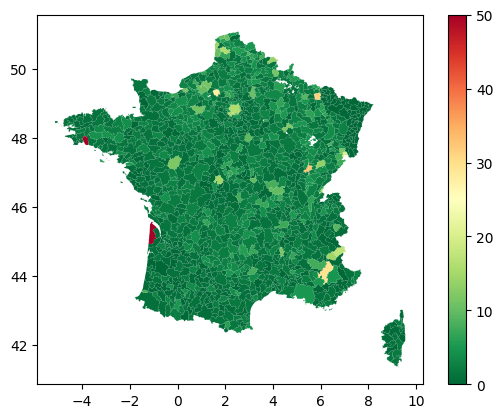

In [107]:
vmin=0
vmax=50
count_dups_epci['full_2017.csv'].plot(column='proportion_dup', cmap='RdYlGn_r', legend=True, vmin=vmin, vmax=vmax);

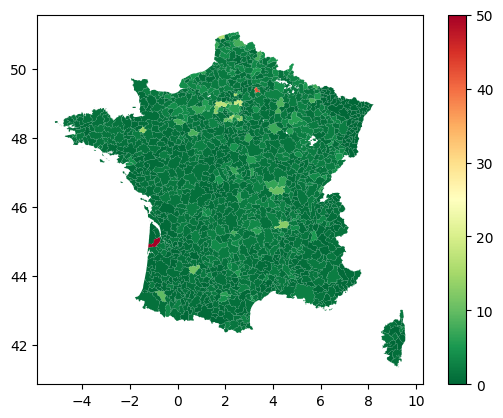

In [108]:
count_dups_epci['full_2018.csv'].plot(column='proportion_dup', cmap='RdYlGn_r', legend=True, vmin=vmin, vmax=vmax);

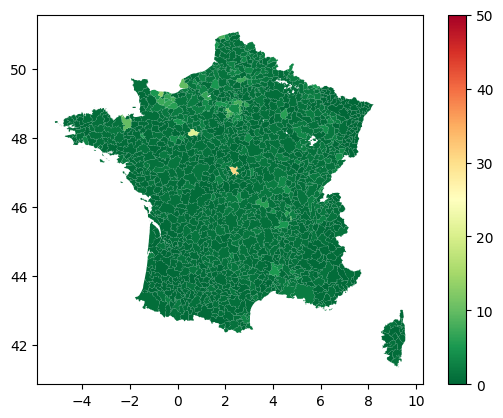

In [109]:
count_dups_epci['full_2019.csv'].plot(column='proportion_dup', cmap='RdYlGn_r', legend=True, vmin=vmin, vmax=vmax);

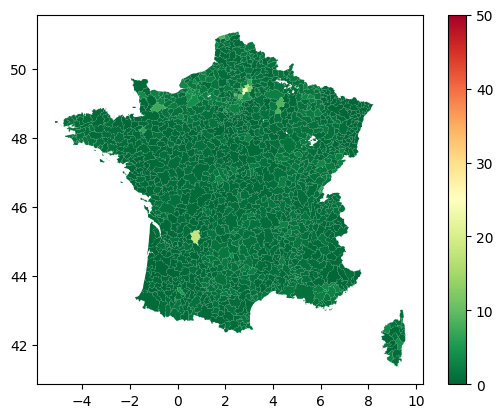

In [110]:
count_dups_epci['full_2020.csv'].plot(column='proportion_dup', cmap='RdYlGn_r', legend=True, vmin=vmin, vmax=vmax);

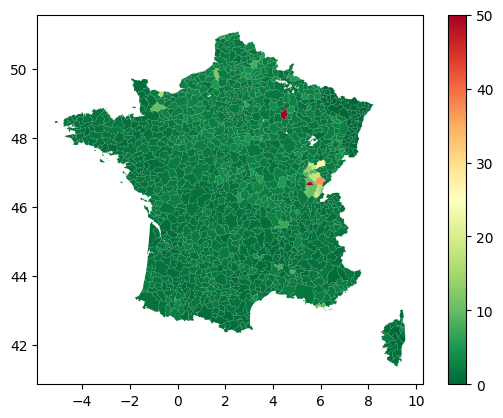

In [111]:
count_dups_epci['full_2021.csv'].plot(column='proportion_dup', cmap='RdYlGn_r', legend=True, vmin=vmin, vmax=vmax);

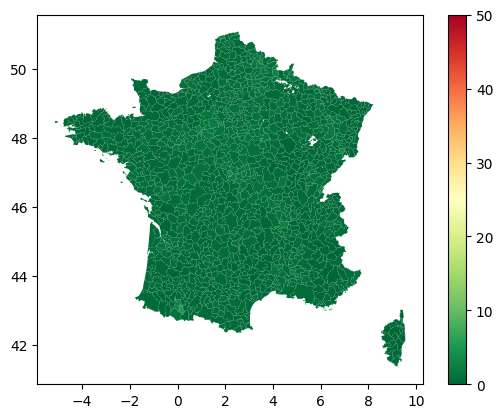

In [112]:
count_dups_epci['full_2022.csv'].plot(column='proportion_dup', cmap='RdYlGn_r', legend=True, vmin=vmin, vmax=vmax);

In [174]:
dups

{'full_2017.csv':          id_mutation date_mutation numero_disposition nature_mutation  \
 47           2017-26    2017-07-13             000002           Vente   
 81           2017-37    2017-07-12             000002         Echange   
 214          2017-99    2017-07-13             000001           Vente   
 311         2017-143    2017-07-05             000001           Vente   
 383         2017-167    2017-07-07             000001           Vente   
 ...              ...           ...                ...             ...   
 1764565  2017-754383    2017-12-15             000001           Vente   
 1764566  2017-754383    2017-12-15             000001           Vente   
 1764572  2017-754383    2017-12-15             000001           Vente   
 1764574  2017-754383    2017-12-15             000001           Vente   
 1764582  2017-754383    2017-12-15             000001           Vente   
 
         valeur_fonciere adresse_numero adresse_suffixe  \
 47               250000          

In [177]:
## cas concrets
dups['full_2017.csv'].loc[dups['full_2017.csv']['id_mutation']=='2017-99']

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
214,2017-99,2017-07-13,000001,Vente,192000,2,B,RUE DE BALOUX,0010,01290,01306,Pont-de-Veyle,01,NaN,NaN,013060000A1261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,Dépendance,NaN,0,S,sols,NaN,NaN,87,4.888263,46.259839


### Types de biens

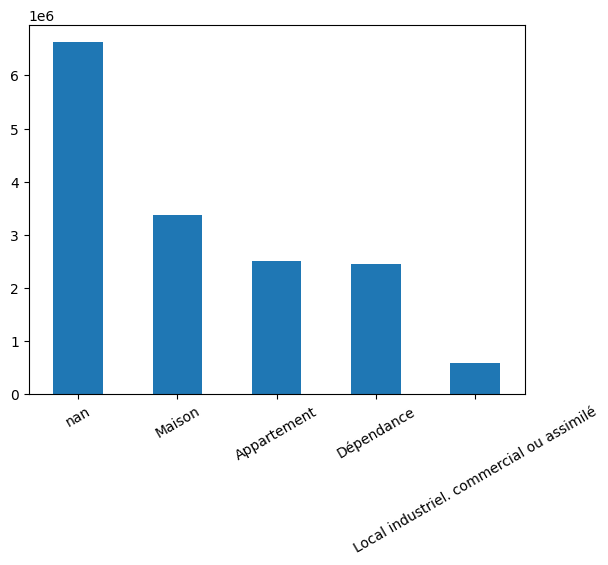

In [34]:
## mutations et types de biens
cross_list = ['nature_mutation', 'type_local']
# df[cross_list].value_counts(dropna=False).unstack().plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1, 0.5))
# plt.xticks(rotation= 30);

df.loc[df['nature_mutation']=='Vente']['type_local'].value_counts(dropna=False).plot(kind='bar')
plt.xticks(rotation= 30);

# cross_list = ['nature_mutation', 'nature_culture']
# df[cross_list].value_counts(dropna=False).reset_index().sort_values(by=cross_list)

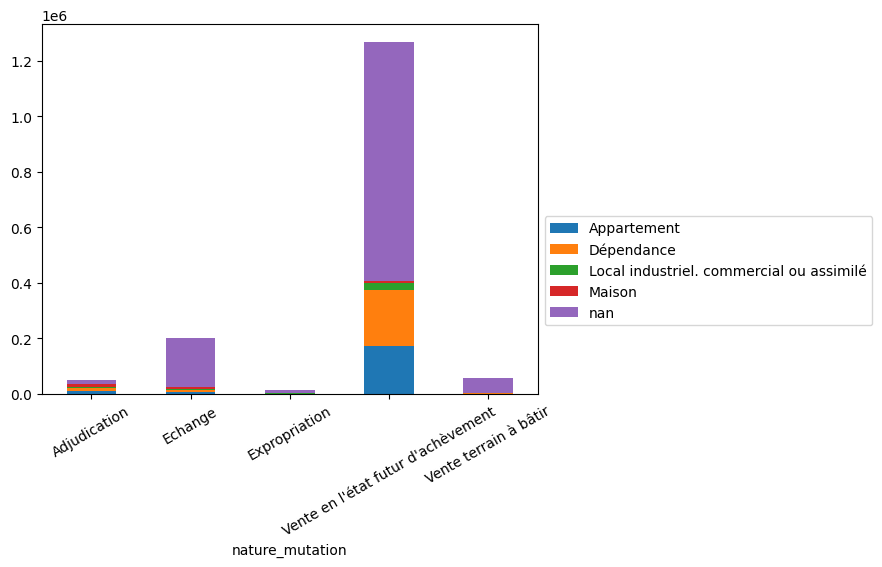

In [35]:
df.loc[~(df['nature_mutation']=='Vente')][cross_list].value_counts(dropna=False).unstack().plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1, 0.5))
plt.xticks(rotation= 30);

In [59]:
## répartition des valeurs
## on sort les doublons de mutations pour ne pas biaiser avec les mutations
df_prix = df.drop_duplicates(subset='id_mutation')
print("Pas de valeur :", round(len(df_prix.loc[df_prix['valeur_fonciere'].isna()])/len(df_prix)*100, 2), "%")
repartition={}
for k in range(0, 11):
    repartition[10**(k-1)]= len(df_prix.loc[df_prix['valeur_fonciere'].between(10**(k-1), (10**k)/4, inclusive='left')])
    repartition[(10**k)/4]= len(df_prix.loc[df_prix['valeur_fonciere'].between((10**k)/4, (10**k)/2, inclusive='left')])
    repartition[(10**k)/2]= len(df_prix.loc[df_prix['valeur_fonciere'].between((10**k)/2, 10**k, inclusive='left')])
    print(f'entre {10**(k-1)}€ et {10**k}€ :', repartition[10**(k-1)]+repartition[(10**k)/4]+repartition[(10**k)/2])
df_rep = pd.DataFrame({'prix': repartition.keys(), 'nb': repartition.values()})
df_rep

Pas de valeur : 0.27 %


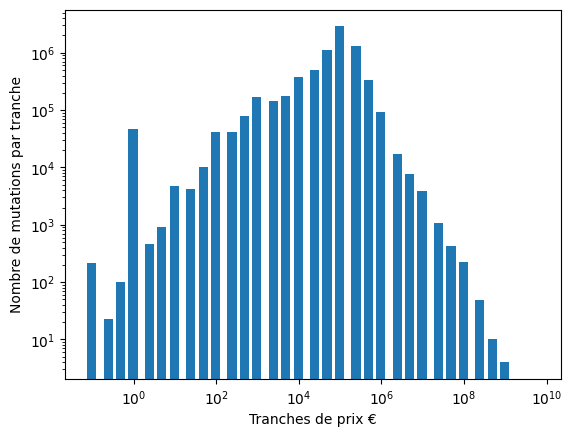

In [13]:
plt.bar(
    df_rep['prix'],
    df_rep['nb'],
    width= df_rep['prix']/2,
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Tranches de prix €")
plt.ylabel("Nombre de mutations par tranche")
plt.show()

# fig = go.Figure(data=[go.Bar(
#     x=df_rep['prix'],
#     y=df_rep['nb'],
#     width=df_rep['prix']/2,
# #     tickmode = 'array',
# #     tickvals = df_rep['prix'],
# #     ticktext = [f"{k}€" for k in df_rep['prix']]
# )])
# fig.update_xaxes(type='log')
# fig.update_yaxes(type='log')
# fig.show()

In [14]:
df.loc[df['valeur_fonciere']<10]['type_local'].value_counts(dropna=False)

NaN                                         107432
Local industriel. commercial ou assimilé      9667
Dépendance                                    4353
Appartement                                   4160
Maison                                        2517
Name: type_local, dtype: int64

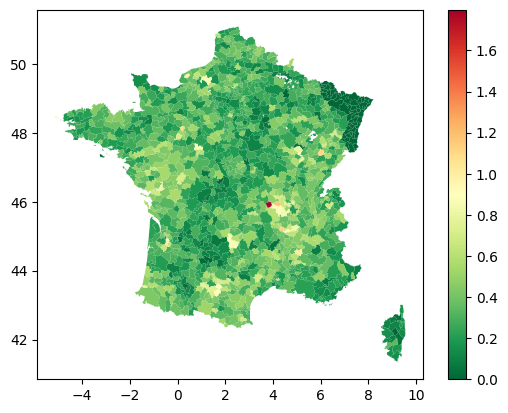

In [156]:
df_all = pd.merge(df[['id_mutation','code_commune']],
                      epci2commune,
                      left_on='code_commune',
                      right_on='INSEE_C',
                      how='left')['EPCI'].value_counts().reset_index().rename({'EPCI': 'nb_mutations'}, axis=1)
seuil_prix = 10
df_prix_bas = pd.merge(df_prix.loc[df_prix['valeur_fonciere']<=seuil_prix][['id_mutation','code_commune']],
                      epci2commune,
                      left_on='code_commune',
                      right_on='INSEE_C',
                      how='left')['EPCI'].value_counts().reset_index().rename({'EPCI': 'nb_discount'}, axis=1)
df_prix_bas = pd.merge(df_prix_bas,
                      df_all,
                      on='index',
                      how='right')
df_prix_bas['proportion_discount'] = df_prix_bas['nb_discount']/df_prix_bas['nb_mutations']*100
epci_prix_bas = gpd.GeoDataFrame(pd.merge(df_prix_bas.rename({'index':'EPCI'}, axis=1),
                                         epci,
                                         on='EPCI',
                                         how='right').fillna(0))
epci_prix_bas.plot(column='proportion_discount', cmap='RdYlGn_r', legend=True);

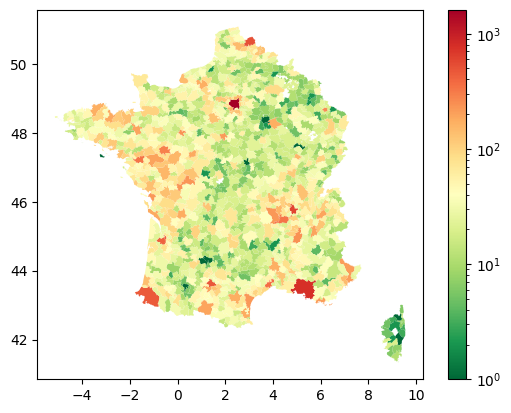

In [161]:
epci_prix_bas.plot(column='nb_discount', cmap='RdYlGn_r', legend=True,
                  norm=matplotlib.colors.LogNorm(vmin=1, vmax=epci_prix_bas['nb_discount'].max())
                  );

### Répartition des surfaces

In [18]:
print("Pas de valeur :", round(len(df.loc[(df['surface_reelle_bati'].isna()) & ~(df['type_local'].isna())])/len(df)*100, 2), "%")
repartition_surf={}
for k in range(0, 7):
    repartition_surf[10**(k-1)]= len(df.loc[df['surface_reelle_bati'].between(10**(k-1), (10**k)/4, inclusive='left')])
    repartition_surf[(10**k)/4]= len(df.loc[df['surface_reelle_bati'].between((10**k)/4, (10**k)/2, inclusive='left')])
    repartition_surf[(10**k)/2]= len(df.loc[df['surface_reelle_bati'].between((10**k)/2, 10**k, inclusive='left')])
    print(f'entre {10**(k-1)}m² et {10**k}m² :', repartition[10**(k-1)]+repartition[(10**k)/2])
df_rep_surf = pd.DataFrame({'surface': repartition_surf.keys(), 'nb': repartition_surf.values()})
df_rep_surf

Pas de valeur : 15.79 %
entre 0.1m² et 1m² : 319
entre 1m² et 10m² : 47886
entre 10m² et 100m² : 14957
entre 100m² et 1000m² : 121012
entre 1000m² et 10000m² : 347132
entre 10000m² et 100000m² : 1497244
entre 100000m² et 1000000m² : 3214449


,surface,nb
0,0.10,0
1,0.25,0
2,0.50,0
3,1.00,3624
4,2.50,2388
5,5.00,13918
6,10.00,379148
7,25.00,1206249
8,50.00,3078593
9,100.00,1807073


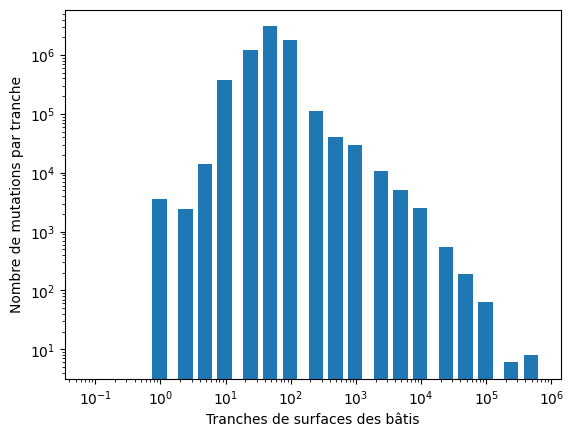

In [19]:
plt.bar(
    df_rep_surf['surface'],
    df_rep_surf['nb'],
    width= df_rep_surf['surface']/2,
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Tranches de surfaces des bâtis")
plt.ylabel("Nombre de mutations par tranche")
plt.show()

In [37]:
### lots, bâti, pièces

print("aucune surface de bien renseignée")
cols_of_interest = [c for c in df.columns if any([s in c for s in ['surface_reelle', 'surface_carrez']])]
temp = df.loc[~(df['type_local'].isna()) & (df[[surf_col for surf_col in cols_of_interest]].isna().all(axis=1))]['type_local'].value_counts(dropna=True)
print(sum(temp)/len(df)*100)
print(temp)

print("\naucune surface")
cols_of_interest = [c for c in df.columns if 'surface' in c]
temp = df.loc[~(df['type_local'].isna()) & (df[[surf_col for surf_col in cols_of_interest]].isna().all(axis=1))]['type_local'].value_counts(dropna=False)
print(sum(temp)/len(df)*100)
print(temp)

print("\npas de surface de bâti mais au moins un lot a une surface (dépendances ok ?)")
cols_of_interest = [c for c in df.columns if 'surface_carrez' in c]
temp = df.loc[~(df['type_local'].isna()) & (df['surface_reelle_bati'].isna()) & (~(df[[surf_col for surf_col in cols_of_interest]].isna()).all(axis=1))]['type_local'].value_counts(dropna=True)
print(sum(temp)/len(df)*100)
print(temp)

print("\nun lot a une plus grande surface que le bâti")
cols_of_interest = [c for c in df.columns if 'surface_carrez' in c]
temp = df.loc[df[[surf_col for surf_col in cols_of_interest]].max(axis=1) > 1.05*df['surface_reelle_bati']]['type_local'].value_counts(dropna=True)
print(sum(temp)/len(df)*100)
print(temp)

print('\nappartement ou maison sans nombre de pièces')
temp = df.loc[df['code_type_local'].isin(['1','2']) & df['nombre_pieces_principales'].isna()]
print(len(temp)/len(df)*100)
temp

aucune surface de bien renseignée
14.27075008838958
Dépendance                                  2414237
Local industriel. commercial ou assimilé      32382
Appartement                                     148
Maison                                           51
Name: type_local, dtype: int64

aucune surface
10.584446723216558
Dépendance                                  1813822
Local industriel. commercial ou assimilé        813
Appartement                                     136
Maison                                            5
Name: type_local, dtype: int64

pas de surface de bâti mais au moins un lot a une surface (dépendances ok ?)
1.5205924102424364
Dépendance                                  260570
Local industriel. commercial ou assimilé       116
Appartement                                     29
Maison                                           1
Name: type_local, dtype: int64

un lot a une plus grande surface que le bâti
1.5488677443410548
Appartement                           

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
69556,2017-29947,2017-08-07,000001,Vente en l'état futur d'achèvement,340000.0,27,NaN,BD CHARLES GUILLAUMONT,0690,06160,06004,Antibes,06,NaN,NaN,06004000CP0343,NaN,NaN,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.105279,43.570556
163706,2017-64713,2017-07-04,000001,Vente,430500.0,17,NaN,RUE ERNEST RENAN,3189,13005,13205,Marseille 5e Arrondissement,13,NaN,NaN,132058190E0231,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39351,43.28695
172305,2017-69513,2017-10-12,000001,Vente,205000.0,14,NaN,AV DE LA BARQUIERE,0762,13009,13209,Marseille 9e Arrondissement,13,NaN,NaN,132098520B0200,NaN,NaN,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39828,43.244482
414958,2017-165267,2017-10-07,000001,Vente,66700.0,5842,F,RTE DU TREUSTEL,0842,29120,29037,Combrit,29,NaN,NaN,29037000AH0454,NaN,NaN,117,38.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.153689,47.866252
483478,2017-195408,2017-12-15,000001,Vente,18000.0,23,NaN,AV DES ETATS UNIS,3104,31200,31555,Toulouse,31,NaN,NaN,31555829AX0158,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.432834,43.628084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272586,2021-1571443,2021-03-16,000001,Vente,320000.0,17,NaN,LOT LONY,A080,97354,97309,Remire-Montjoly,973,NaN,NaN,97309000AC0784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,NaN,NaN,S,sols,NaN,NaN,1059.0,-52.282859,4.922113
4286342,2021-1577237,2021-10-14,000001,Vente,350000.0,13,NaN,ALL DES OPALES,1027,97400,97411,Saint-Denis,974,NaN,NaN,97411000DE0250,NaN,NaN,8,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.445232,-20.892732
640442,2022-230107,2022-06-01,000001,Vente,372500.0,24,NaN,MAIL SUD,0978,45300,45252,Pithiviers,45,NaN,NaN,45252000AK0106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,NaN,NaN,S,sols,NaN,NaN,229.0,2.255575,48.171167
902184,2022-330880,2022-04-29,000001,Vente,146220.0,41,NaN,AV JACQUES DUCLOS,0855,69200,69259,Vénissieux,69,NaN,NaN,69259000BS0110,NaN,NaN,9,42.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.894086,45.698423


In [18]:
# types
print("aucun type renseigné (local, culture, culture spéciale)")
no_type = df.loc[(df['code_type_local'].isna()) & (df['code_nature_culture'].isna()) & (df['code_nature_culture_speciale'].isna())]
print(round(len(no_type)/len(df)*100, 2), "% du nombre de lignes")

print("mutations sans type")
full_no_type = pd.DataFrame(None)
for c in ['code_type_local', 'code_nature_culture', 'code_nature_culture_speciale']:
    if len(full_no_type)==0:
        full_no_type = df.loc[df['id_mutation'].isin(no_type['id_mutation'])].groupby('id_mutation')[c].apply(list).reset_index()
    else:
        full_no_type = pd.merge(full_no_type, df.loc[df['id_mutation'].isin(no_type['id_mutation'])].groupby('id_mutation')[c].apply(list).reset_index(), on='id_mutation', how='outer')

full_no_type = full_no_type.loc[pd.Series(np.product([full_no_type[c].apply(lambda l: all([not(isinstance(k, str)) for k in l])) for c in full_no_type.columns if 'code_' in c], axis=0)).astype(bool)]
print(round(len(full_no_type)/len(df['id_mutation'].drop_duplicates())*100, 2), "% du nombre de mutations")
print("natures mutations de ces biens :")
print(df.loc[df['id_mutation'].isin(full_no_type['id_mutation'])]['nature_mutation'].value_counts(dropna=False))
full_no_type

aucun type renseigné (local, culture, culture spéciale)
5.01 % du nombre de lignes
mutations sans type
4.52 % du nombre de mutations
natures mutations de ces biens :
Vente en l'état futur d'achèvement    794327
Vente                                  24130
Expropriation                            956
Echange                                  836
Vente terrain à bâtir                    124
Adjudication                              24
Name: nature_mutation, dtype: int64


,id_mutation,code_type_local,code_nature_culture,code_nature_culture_speciale
2,2017-100055,"[nan, nan]","[nan, nan]","[nan, nan]"
3,2017-100056,"[nan, nan]","[nan, nan]","[nan, nan]"
4,2017-100083,"[nan, nan]","[nan, nan]","[nan, nan]"
5,2017-100123,"[nan, nan]","[nan, nan]","[nan, nan]"
6,2017-100248,"[nan, nan]","[nan, nan]","[nan, nan]"
...,...,...,...,...
355224,2022-99894,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]"
355225,2022-99895,[nan],[nan],[nan]
355226,2022-99936,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]"
355227,2022-99947,"[nan, nan]","[nan, nan]","[nan, nan]"


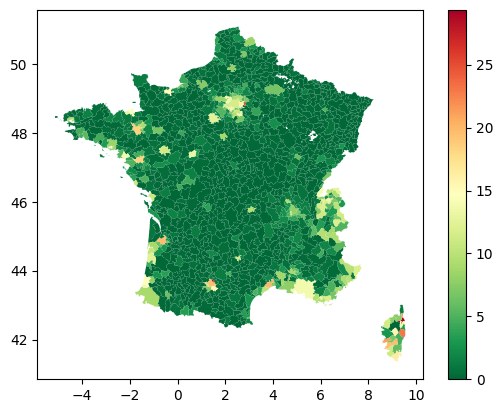

In [170]:
df_all = pd.merge(df[['id_mutation','code_commune']],
                      epci2commune,
                      left_on='code_commune',
                      right_on='INSEE_C',
                      how='left')['EPCI'].value_counts().reset_index().rename({'EPCI': 'nb_mutations'}, axis=1)
df_no_type = pd.merge(no_type[['id_mutation','code_commune']],
                      epci2commune,
                      left_on='code_commune',
                      right_on='INSEE_C',
                      how='left')['EPCI'].value_counts().reset_index().rename({'EPCI': 'nb_no_type'}, axis=1)
df_no_type = pd.merge(df_no_type,
                      df_all,
                      on='index',
                      how='right').fillna(0.01)
df_no_type['proportion_no_type'] = df_no_type['nb_no_type']/df_no_type['nb_mutations']*100
epci_no_type = gpd.GeoDataFrame(pd.merge(df_no_type.rename({'index':'EPCI'}, axis=1),
                                         epci,
                                         on='EPCI',
                                         how='right').fillna(0))
epci_no_type.plot(column='proportion_no_type', cmap='RdYlGn_r',
                  legend=True);

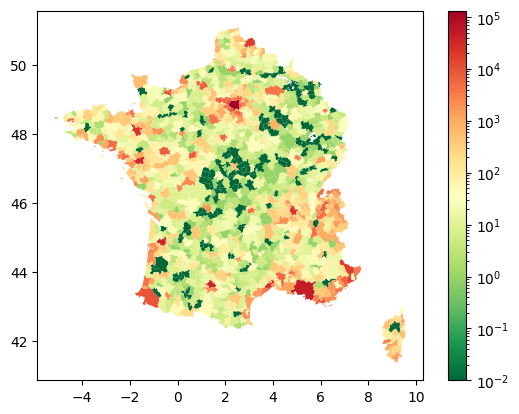

In [171]:
epci_no_type.plot(column='nb_no_type', cmap='RdYlGn_r',
                  legend=True,
                  norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=epci_no_type['nb_no_type'].max())
                  );

In [19]:
df.loc[df['id_mutation']=='2017-100248']

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
244368,2017-100248,2017-08-09,000001,Vente en l'état futur d'achèvement,211000.0,NaN,NaN,NaN,NaN,NaN,17300,La Rochelle,17,NaN,NaN,17300000AI0126,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.144632,46.161254
244369,2017-100248,2017-08-09,000001,Vente en l'état futur d'achèvement,211000.0,1,NaN,RUE BONPLAND,1060,17000,17300,La Rochelle,17,NaN,NaN,17300000AI0126,NaN,NaN,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.144632,46.161254


In [20]:
## ventes sans aucun type
df.loc[(df['id_mutation'].isin(full_no_type['id_mutation'])) & (df['nature_mutation']=='Vente')]

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
3088,2017-1317,2017-10-19,000001,Vente,110000.0,NaN,NaN,COLIGNY LE HAUT,B050,01270,01108,Coligny,01,NaN,NaN,01108000AD0044,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.344019,46.382684
3089,2017-1317,2017-10-19,000001,Vente,110000.0,NaN,NaN,COLIGNY LE HAUT,B050,01270,01108,Coligny,01,NaN,NaN,01108000AD0044,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.344019,46.382684
9393,2017-3681,2017-09-29,000001,Vente,224000.0,NaN,NaN,NaN,NaN,NaN,01079,Champagne-en-Valromey,01,NaN,NaN,010790000B0351,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.67852,45.904331
9810,2017-3870,2017-10-11,000001,Vente,70000.0,27,NaN,CHE DE LA PLANCHE BRULEE,0055,01210,01160,Ferney-Voltaire,01,NaN,NaN,01160000AC0108,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099265,46.250559
9909,2017-3918,2017-09-21,000001,Vente,143000.0,NaN,NaN,LE VILLAGE,B141,01100,01014,Arbent,01,NaN,NaN,01014000AB0076,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.681806,46.295845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420158,2022-532925,2022-04-27,000001,Vente,25188088.0,1,B,BD VICTOR,9743,75015,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000EX0008,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.278984,48.836326
1420445,2022-533065,2022-05-13,000001,Vente,830000.0,24,NaN,RUE DU TEXEL,9224,75014,75114,Paris 14e Arrondissement,75,NaN,NaN,75114000DQ0150,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.32006,48.836253
1425827,2022-535799,2022-06-24,000001,Vente,1673550.6,4,NaN,RUE GERMAINE KRULL,4167,75013,75113,Paris 13e Arrondissement,75,NaN,NaN,75113000DA0121,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.358891,48.817215
1427435,2022-536522,2022-05-23,000001,Vente,16342800.0,13,NaN,RUE DE L ASSOMPTION,0503,75016,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000BU0056,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.273617,48.853092


## Terrains

<AxesSubplot:>

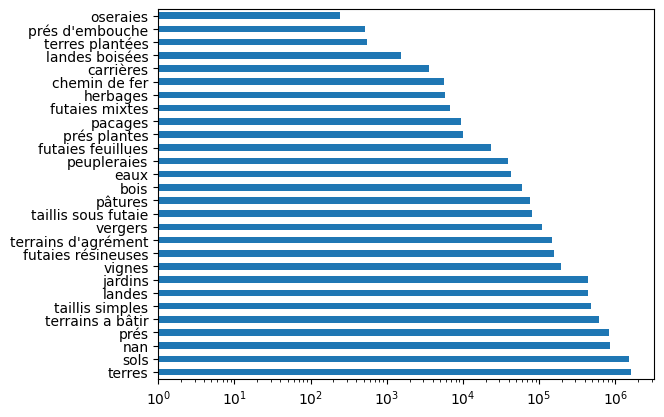

In [40]:
## toutes les cultures simples référencées
df.loc[df['type_local'].isna()]['nature_culture'].value_counts(dropna=False).plot(kind='barh', log=1)

In [22]:
## les natures des cultures des mutations catégorisées "Vente terrain à bâtir"
df.loc[df['nature_mutation']=='Vente terrain à bâtir']['nature_culture'].value_counts(dropna=False)

terrains a bâtir       35285
sols                    8014
terres                  6933
prés                    2507
NaN                     1526
terrains d'agrément      990
landes                   757
jardins                  537
taillis simples          505
vignes                   307
vergers                  263
futaies résineuses       214
pâtures                  156
bois                      80
taillis sous futaie       74
eaux                      45
chemin de fer             38
pacages                   26
prés plantes              21
futaies feuillues         21
peupleraies               13
herbages                   8
futaies mixtes             5
prés d'embouche            4
carrières                  2
Name: nature_culture, dtype: int64

In [23]:
## les natures des mutations sans type_local (NA) et avec culture = "terrains a bâtir"
df.loc[(df['nature_culture']=='terrains a bâtir') & (df['type_local'].isna())]['nature_mutation'].value_counts(dropna=False)

Vente                                 547783
Vente terrain à bâtir                  35020
Vente en l'état futur d'achèvement     30323
Echange                                 3403
Adjudication                             648
Expropriation                            103
Name: nature_mutation, dtype: int64

In [24]:
## on filtre les les mutations avec terrains à batir dans nature_culture mais pas dans nature_mutation
ids_terrains_a_batir = df.loc[(df['nature_culture']=='terrains a bâtir') & (df['nature_mutation']!='Vente terrain à bâtir')]['id_mutation'].drop_duplicates()
## on filtre parmi ces terrains ceux dont les nature_culture sont variées (plusieurs nature_culture dans une même mutation)
ids_multi_culture = df.loc[(df['id_mutation'].isin(ids_terrains_a_batir)) & (df['nature_culture']!='terrains a bâtir')]['id_mutation'].drop_duplicates()
terrains = df.loc[(df['id_mutation'].isin(ids_terrains_a_batir)) & ~(df['id_mutation'].isin(ids_multi_culture))]
## on filtre les mutations multitypes selon type_local
multitypes = terrains[['id_mutation', 'type_local']].value_counts(dropna=False).unstack()
mutations_drop = multitypes.loc[sum([multitypes[c].isna() for c in multitypes.columns])<len(multitypes.columns)-1].index

## finalement : des uniquement mutations de terrains à batir selon nature_culture, mais pas selon nature_mutation
terrains.loc[~(terrains['id_mutation'].isin(mutations_drop))]
## par exemple : 75120000DZ0009 et 75101000AV0025

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
28,2017-19,2017-07-06,000001,Vente,44800.0,NaN,NaN,BIEF GODARD,B005,01290,01134,Crottet,01,NaN,NaN,011340000C2472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,752.0,NaN,NaN
29,2017-20,2017-07-10,000001,Vente,212010.0,586,S,RTE DU CORRIDOR,0185,01380,01025,Bâgé-Dommartin,01,01025,Bâgé-la-Ville,010250000F2429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,131.0,5.0,AB,terrains a bâtir,NaN,NaN,888.0,4.940865,46.318774
98,2017-44,2017-07-03,000001,Vente,45000.0,NaN,NaN,PRE ROMAINE,B070,01270,01432,Verjon,01,NaN,NaN,014320000B1509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,1500.0,5.348077,46.345956
102,2017-48,2017-07-06,000001,Vente,73000.0,NaN,NaN,PRAIRIE DE MONTPLAISANT,B050,01250,01254,Montagnat,01,NaN,NaN,01254000AR0151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,629.0,5.293374,46.168375
203,2017-94,2017-07-10,000001,Vente,184000.0,NaN,NaN,LA GRIPINIERE,B003,01380,01026,Bâgé-le-Châtel,01,NaN,NaN,010260000A1131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,324.0,4.928074,46.311113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379553,2022-513914,2022-06-23,000001,Vente,70000.0,NaN,NaN,CHE DAUPHIN,0130,97429,97405,Petite-Île,974,NaN,NaN,97405000AM0870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,409.0,55.569339,-21.343279
1379641,2022-513965,2022-06-24,000001,Vente,152250.0,NaN,NaN,RIVIERE DES ROCHES,B100,97412,97402,Bras-Panon,974,NaN,NaN,97402000AK1945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,406.0,55.687217,-21.006541
1379710,2022-513994,2022-06-27,000001,Vente,6000.0,24,A,CHE DES HERBES ROSES,0645,97421,97414,Saint-Louis,974,NaN,NaN,97414000EK0671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,131.0,55.427578,-21.265966
1382963,2022-515753,2022-01-28,000001,Vente,2000000.0,83,A,RUE MANIN,5976,75019,75119,Paris 19e Arrondissement,75,NaN,NaN,75119000EM0092,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,600.0,2.384267,48.883208


In [4]:
## filling type_local NA from nature_culture
df_ = df.copy()
df_.loc[df_['type_local'].isna(), 'type_local'] = df_.loc[df_['type_local'].isna(), 'nature_culture']
df_['type_local'].value_counts(dropna=False)

Maison                                      3397774
Appartement                                 2698000
Dépendance                                  2674807
terres                                      1590308
sols                                        1516407
NaN                                          858440
prés                                         827047
Local industriel. commercial ou assimilé     629833
terrains a bâtir                             617280
taillis simples                              481047
landes                                       444229
jardins                                      433624
vignes                                       192734
futaies résineuses                           157486
terrains d'agrément                          147815
vergers                                      110785
taillis sous futaie                           81549
pâtures                                       77019
bois                                          59138
eaux        

In [9]:
print(len(df_))
multitypes = df_[['id_mutation', 'type_local']].value_counts()
multitypes_ = multitypes.unstack()
mutations_drop = multitypes_.loc[sum([multitypes_[c].isna() for c in multitypes_.columns])<len(multitypes_.columns)-1].index
ventes_nodup = df_.loc[~(df_['id_mutation'].isin(mutations_drop))]
print(len(ventes_nodup))

17145686
6055697


In [6]:
## changer le type ici pour toutes les cellules suivantes
type_ = 'terrains a bâtir'

### Surfaces

642600


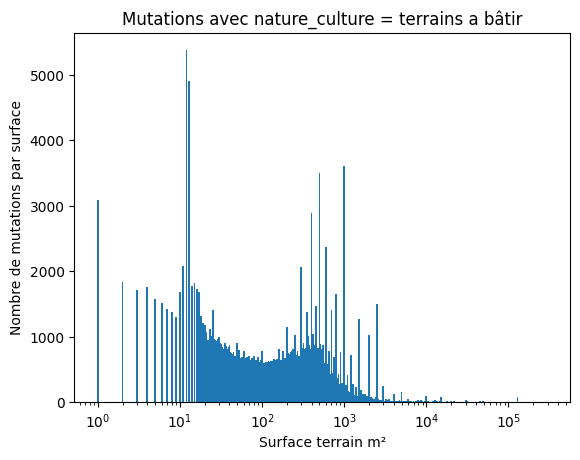

In [44]:
## données brutes (dont terrains inclus dans type_local autre)
repartition_surfaces_terrains = df_[df_['nature_culture']==type_]['surface_terrain'].value_counts(dropna=True)
print(sum(repartition_surfaces_terrains))
plt.bar(
    repartition_surfaces_terrains.index,
    repartition_surfaces_terrains,
    width=np.array(repartition_surfaces_terrains.index)/20,
)
plt.xscale('log')
plt.title('Mutations avec nature_culture = '+ type_)
plt.xlabel("Surface terrain m²")
plt.ylabel("Nombre de mutations par surface")
plt.show()

entre 0.1€m²et 1m² : 0
entre 1€m²et 10m² : 15595
entre 10€m²et 100m² : 82295
entre 100€m²et 1000m² : 437216
entre 1000€m²et 10000m² : 104070
entre 10000€m²et 100000m² : 3320


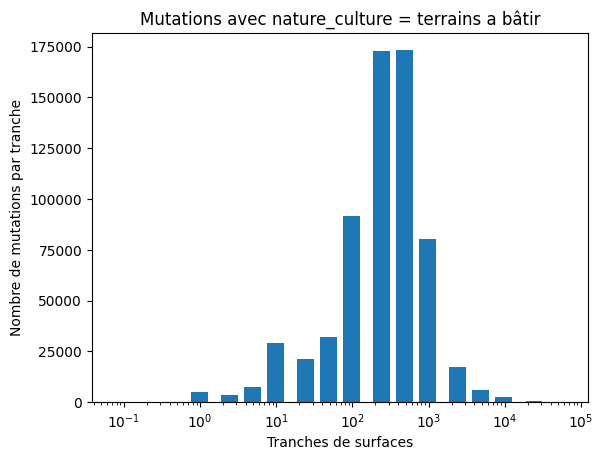

In [8]:
## répartition des surfaces par tranche
df_surf = df[df['nature_culture']==type_]
repartition={}
for k in range(0, 6):
    repartition[10**(k-1)]= len(df_surf.loc[df_surf['surface_terrain'].between(10**(k-1), (10**k)/4, inclusive='left')])
    repartition[(10**k)/4]= len(df_surf.loc[df_surf['surface_terrain'].between((10**k)/4, (10**k)/2, inclusive='left')])
    repartition[(10**k)/2]= len(df_surf.loc[df_surf['surface_terrain'].between((10**k)/2, 10**k, inclusive='left')])
    print(f'entre {10**(k-1)}€m²et {10**k}m² :', repartition[10**(k-1)]+repartition[(10**k)/4]+repartition[(10**k)/2])
df_rep = pd.DataFrame({'surface': repartition.keys(), 'nb': repartition.values()})
plt.bar(
    df_rep['surface'],
    df_rep['nb'],
    width= df_rep['surface']/2,
)
plt.xscale('log')
plt.title('Mutations avec nature_culture = '+ type_)
plt.xlabel("Tranches de surfaces")
plt.ylabel("Nombre de mutations par tranche")
plt.show()

617273


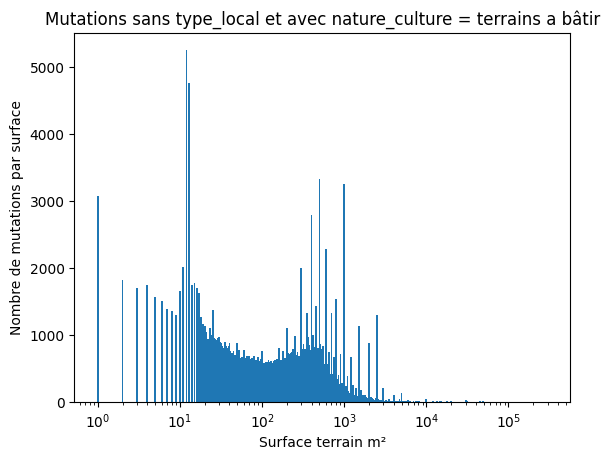

In [10]:
## données brutes terrains seuls
repartition_surfaces_terrains = df_[df_['type_local']==type_]['surface_terrain'].value_counts(dropna=True)
print(sum(repartition_surfaces_terrains))
plt.bar(
    repartition_surfaces_terrains.index,
    repartition_surfaces_terrains,
    width=np.array(repartition_surfaces_terrains.index)/20,
)
plt.xscale('log')
plt.title('Mutations sans type_local et avec nature_culture = '+ type_)
plt.xlabel("Surface terrain m²")
plt.ylabel("Nombre de mutations par surface")
plt.show()

421230


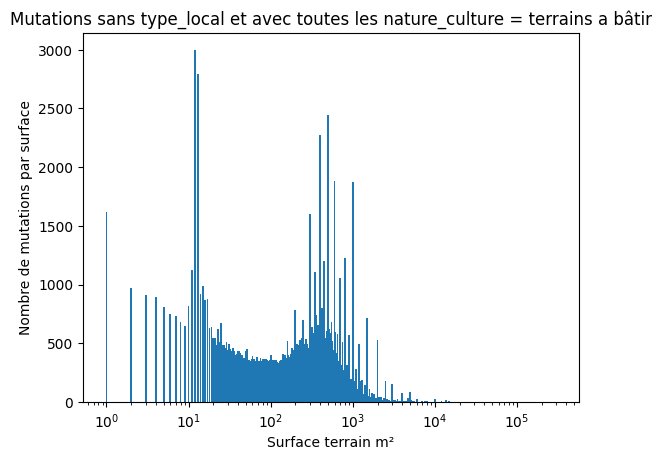

In [11]:
## en ne gardant que les mutations monotypes
repartition_surfaces_terrains = ventes_nodup[ventes_nodup['type_local']==type_]['surface_terrain'].value_counts(dropna=True)
print(sum(repartition_surfaces_terrains))
plt.bar(
    repartition_surfaces_terrains.index,
    repartition_surfaces_terrains,
    width=np.array(repartition_surfaces_terrains.index)/20,
)
plt.xscale('log')
plt.title('Mutations sans type_local et avec toutes les nature_culture = '+ type_)
plt.xlabel("Surface terrain m²")
plt.ylabel("Nombre de mutations par surface")
plt.show()

416646


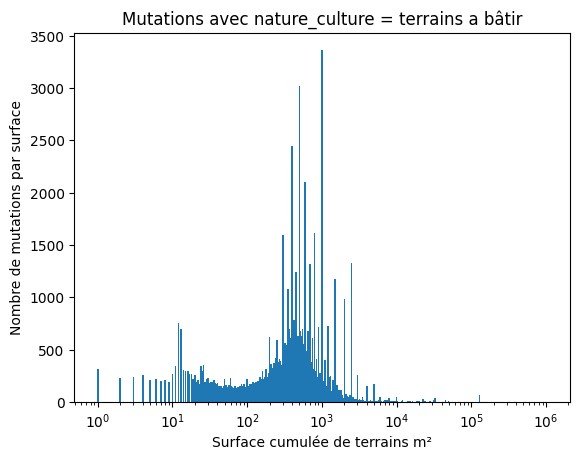

In [12]:
## en sommant les surfaces par mutation (dont terrains inclus dans type_local autre)
grouped = df_.loc[df_['nature_culture']==type_].groupby(['id_mutation'])['surface_terrain'].sum().reset_index()
repartition_surfaces_terrains = grouped['surface_terrain'].value_counts(dropna=True)
print(sum(repartition_surfaces_terrains))
plt.bar(
    repartition_surfaces_terrains.index,
    repartition_surfaces_terrains,
    width=np.array(repartition_surfaces_terrains.index)/20,
)
plt.xscale('log')
plt.title('Mutations avec nature_culture = '+ type_)
plt.xlabel("Surface cumulée de terrains m²")
plt.ylabel("Nombre de mutations par surface")
plt.show()

299309


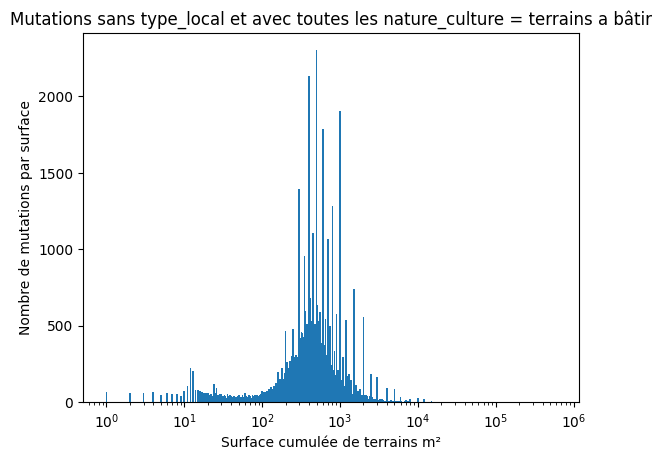

In [13]:
## en sommant les surfaces par mutation monotype uniquement
## ce sont ces mutations qui seraient utilisées dans le fichier stats si on incluait les terrains
grouped = ventes_nodup.loc[ventes_nodup['type_local']==type_].groupby(['id_mutation'])['surface_terrain'].sum().reset_index()
repartition_surfaces_terrains = grouped['surface_terrain'].value_counts(dropna=True)
print(sum(repartition_surfaces_terrains))
plt.bar(
    repartition_surfaces_terrains.index,
    repartition_surfaces_terrains,
    width=np.array(repartition_surfaces_terrains.index)/20,
)
plt.xscale('log')
plt.title('Mutations sans type_local et avec toutes les nature_culture = '+ type_)
plt.xlabel("Surface cumulée de terrains m²")
plt.ylabel("Nombre de mutations par surface")
plt.show()

entre 0.1€m²et 1m² : 0
entre 1€m²et 10m² : 494
entre 10€m²et 100m² : 4249
entre 100€m²et 1000m² : 230416
entre 1000€m²et 10000m² : 62046
entre 10000€m²et 100000m² : 2062


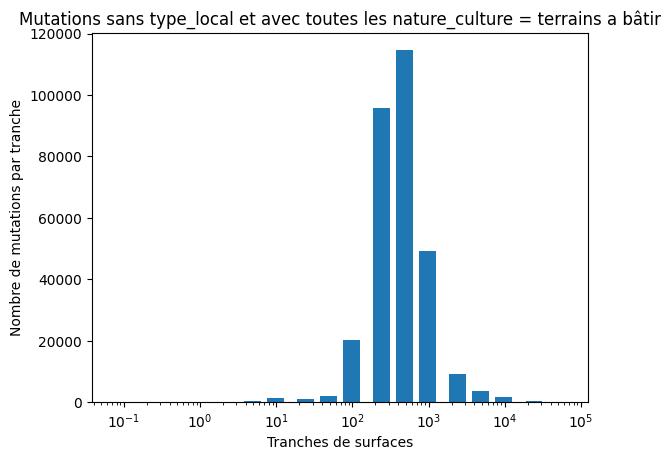

In [10]:
## en sommant les surfaces par mutation monotype uniquement
## ce sont ces mutations qui seraient utilisées dans le fichier stats si on incluait les terrains
grouped = ventes_nodup.loc[ventes_nodup['type_local']==type_].groupby(['id_mutation'])['surface_terrain'].sum().reset_index()
repartition={}
for k in range(0, 6):
    repartition[10**(k-1)]= len(grouped.loc[grouped['surface_terrain'].between(10**(k-1), (10**k)/4, inclusive='left')])
    repartition[(10**k)/4]= len(grouped.loc[grouped['surface_terrain'].between((10**k)/4, (10**k)/2, inclusive='left')])
    repartition[(10**k)/2]= len(grouped.loc[grouped['surface_terrain'].between((10**k)/2, 10**k, inclusive='left')])
    print(f'entre {10**(k-1)}€m²et {10**k}m² :', repartition[10**(k-1)]+repartition[(10**k)/4]+repartition[(10**k)/2])
df_rep = pd.DataFrame({'surface': repartition.keys(), 'nb': repartition.values()})
plt.bar(
    df_rep['surface'],
    df_rep['nb'],
    width= df_rep['surface']/2,
)
plt.xscale('log')
plt.title('Mutations sans type_local et avec toutes les nature_culture = '+ type_)
plt.xlabel("Tranches de surfaces")
plt.ylabel("Nombre de mutations par tranche")
plt.show()

### Prix m²

297983


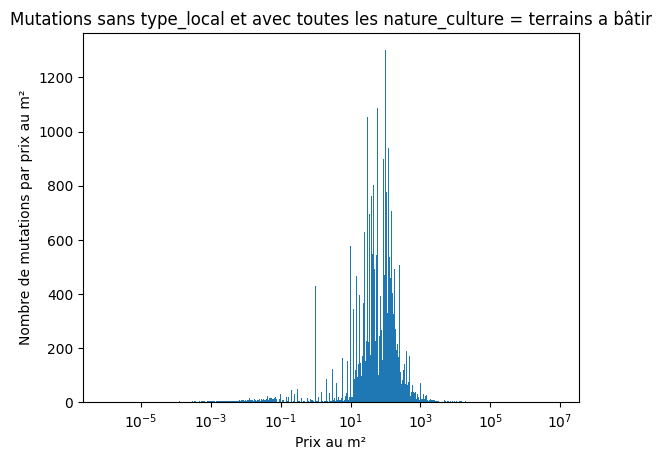

In [14]:
## uniquement pour les mutations monotypes (sinon pas de sens)
restr = ventes_nodup.loc[ventes_nodup['type_local']==type_]
surfaces = restr.groupby(['id_mutation'])['surface_terrain'].sum().reset_index()
surfaces.columns = ['id_mutation', 'surface_totale_terrain_mutation']
## tous les prix sont identiques par mutation, mean = prix
prix = restr.groupby(['id_mutation'])['valeur_fonciere'].mean().reset_index()
prix.columns = ['id_mutation', 'prix_mutation']
merged = pd.merge(surfaces, prix, on='id_mutation')
merged['prix_m2'] = merged['prix_mutation']/merged['surface_totale_terrain_mutation']
repartition_prix_m2 = merged['prix_m2'].value_counts(dropna=True)
print(sum(repartition_prix_m2))
plt.bar(
    repartition_prix_m2.index,
    repartition_prix_m2,
    width=np.array(repartition_prix_m2.index)/20,
)
plt.xscale('log')
plt.title('Mutations sans type_local et avec toutes les nature_culture = '+ type_)
plt.xlabel("Prix au m²")
plt.ylabel("Nombre de mutations par prix au m²")
plt.show()

entre 0.1€ et 1€ : 1369
entre 1€ et 10€ : 6340
entre 10€ et 100€ : 116373
entre 100€ et 1000€ : 156788
entre 1000€ et 10000€ : 13507
entre 10000€ et 100000€ : 454


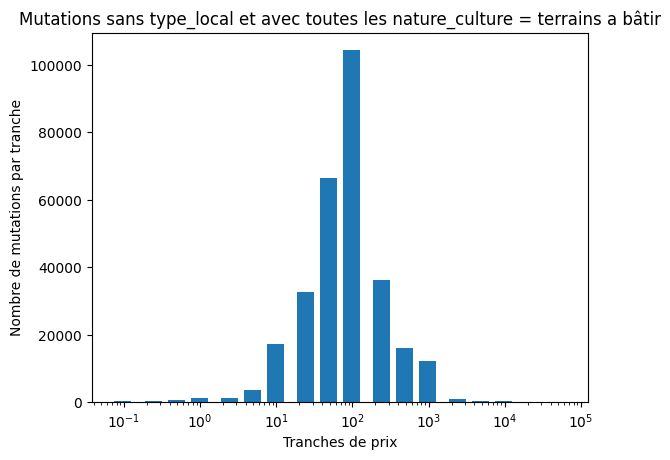

In [11]:
restr = ventes_nodup.loc[ventes_nodup['type_local']==type_]
surfaces = restr.groupby(['id_mutation'])['surface_terrain'].sum().reset_index()
surfaces.columns = ['id_mutation', 'surface_totale_terrain_mutation']
## tous les prix sont identiques par mutation, mean = prix
prix = restr.groupby(['id_mutation'])['valeur_fonciere'].mean().reset_index()
prix.columns = ['id_mutation', 'prix_mutation']
merged = pd.merge(surfaces, prix, on='id_mutation')
merged['prix_m2'] = merged['prix_mutation']/merged['surface_totale_terrain_mutation']
repartition={}
for k in range(0, 6):
    repartition[10**(k-1)]= len(merged.loc[merged['prix_m2'].between(10**(k-1), (10**k)/4, inclusive='left')])
    repartition[(10**k)/4]= len(merged.loc[merged['prix_m2'].between((10**k)/4, (10**k)/2, inclusive='left')])
    repartition[(10**k)/2]= len(merged.loc[merged['prix_m2'].between((10**k)/2, 10**k, inclusive='left')])
    print(f'entre {10**(k-1)}€ et {10**k}€ :', repartition[10**(k-1)]+repartition[(10**k)/4]+repartition[(10**k)/2])
df_rep = pd.DataFrame({'prix': repartition.keys(), 'nb': repartition.values()})
plt.bar(
    df_rep['prix'],
    df_rep['nb'],
    width= df_rep['prix']/2,
)
plt.xscale('log')
plt.title('Mutations sans type_local et avec toutes les nature_culture = '+ type_)
plt.xlabel("Tranches de prix")
plt.ylabel("Nombre de mutations par tranche")
plt.show()

## Données manquantes ?

In [92]:
epci_local = pd.read_csv('epci.csv', dtype=str).drop('libelle_geo', axis=1)

In [93]:
df_epci_month = pd.merge(df[['id_mutation', 'date_mutation', 'code_commune']], epci_local, on='code_commune', how='left')
df_epci_month['month'] = df_epci_month['date_mutation'].str.slice(0,7)

In [94]:
# cross = df_epci_month.loc[df_epci_month['month']>='2022'][['code_epci', 'month']].value_counts()
cross = df_epci_month[['code_epci', 'month']].value_counts()

In [104]:
## on cherche les EPCI avec un écart relatif fort
unstacked = cross.unstack().fillna(0)
unstacked['nb_mutations_std/max'] = unstacked.std(axis=1)/unstacked.max(axis=1)
unstacked.sort_values('nb_mutations_std/max')

month,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,nb_mutations_std/max
code_epci,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200040947,377.0,226.0,250.0,285.0,224.0,515.0,293.0,230.0,245.0,255.0,177.0,372.0,318.0,207.0,964.0,358.0,275.0,379.0,321.0,333.0,361.0,299.0,292.0,317.0,361.0,252.0,300.0,335.0,261.0,435.0,239.0,272.0,233.0,160.0,328.0,381.0,277.0,203.0,351.0,380.0,303.0,390.0,262.0,258.0,325.0,296.0,364.0,439.0,488.0,300.0,359.0,366.0,338.0,530.0,344.0,290.0,373.0,309.0,317.0,321.0,0.116311
200068658,239.0,81.0,109.0,170.0,158.0,188.0,113.0,119.0,900.0,90.0,180.0,154.0,182.0,131.0,117.0,153.0,165.0,143.0,95.0,186.0,178.0,136.0,185.0,222.0,222.0,92.0,180.0,196.0,214.0,180.0,113.0,150.0,109.0,74.0,183.0,180.0,140.0,120.0,195.0,224.0,170.0,262.0,196.0,190.0,202.0,196.0,133.0,259.0,243.0,185.0,176.0,201.0,149.0,233.0,113.0,190.0,196.0,123.0,115.0,170.0,0.116689
200010650,225.0,195.0,203.0,265.0,248.0,217.0,226.0,153.0,274.0,152.0,161.0,213.0,201.0,168.0,240.0,226.0,163.0,250.0,192.0,123.0,200.0,206.0,221.0,169.0,183.0,154.0,219.0,281.0,148.0,206.0,179.0,152.0,130.0,117.0,154.0,221.0,229.0,180.0,167.0,224.0,174.0,251.0,223.0,165.0,247.0,232.0,175.0,323.0,805.0,195.0,374.0,250.0,305.0,399.0,212.0,216.0,271.0,211.0,264.0,254.0,0.116706
200068500,240.0,232.0,258.0,234.0,228.0,253.0,203.0,245.0,212.0,218.0,227.0,249.0,212.0,175.0,239.0,183.0,200.0,258.0,186.0,192.0,313.0,179.0,223.0,266.0,309.0,210.0,271.0,250.0,197.0,328.0,195.0,195.0,208.0,115.0,216.0,257.0,290.0,176.0,259.0,341.0,262.0,276.0,205.0,193.0,290.0,285.0,289.0,398.0,388.0,238.0,453.0,369.0,283.0,832.0,283.0,334.0,365.0,331.0,326.0,310.0,0.117533
200070720,1547.0,248.0,278.0,261.0,248.0,550.0,742.0,205.0,317.0,308.0,402.0,334.0,356.0,192.0,259.0,269.0,248.0,419.0,274.0,266.0,348.0,318.0,245.0,263.0,289.0,233.0,366.0,324.0,252.0,386.0,358.0,316.0,185.0,84.0,252.0,357.0,391.0,221.0,294.0,384.0,273.0,513.0,264.0,285.0,287.0,298.0,347.0,378.0,391.0,260.0,411.0,369.0,319.0,392.0,286.0,366.0,416.0,309.0,294.0,341.0,0.119339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200071199,119.0,107.0,147.0,79.0,84.0,150.0,116.0,92.0,88.0,83.0,76.0,87.0,150.0,78.0,72.0,81.0,53.0,111.0,101.0,80.0,69.0,141.0,67.0,90.0,125.0,130.0,58.0,89.0,72.0,118.0,149.0,94.0,35.0,38.0,127.0,79.0,87.0,62.0,132.0,98.0,65.0,117.0,112.0,75.0,138.0,114.0,79.0,113.0,67.0,18.0,11.0,7.0,0.0,12.0,19.0,5.0,28.0,20.0,40.0,14.0,0.274886
200069177,165.0,144.0,211.0,153.0,125.0,189.0,125.0,112.0,146.0,116.0,130.0,141.0,218.0,129.0,173.0,156.0,142.0,156.0,157.0,162.0,159.0,174.0,144.0,156.0,176.0,147.0,133.0,216.0,163.0,176.0,106.0,216.0,115.0,63.0,123.0,201.0,126.0,186.0,215.0,184.0,131.0,195.0,101.0,168.0,145.0,182.0,112.0,207.0,85.0,18.0,17.0,12.0,3.0,37.0,8.0,20.0,24.0,24.0,39.0,55.0,0.279222
200041465,276.0,189.0,111.0,160.0,330.0,255.0,156.0,101.0,107.0,229.0,306.0,175.0,176.0,122.0,98.0,117.0,259.0,99.0,117.0,186.0,312.0,100.0,228.0,99.0,189.0,112.0,170.0,232.0,140.0,191.0,83.0,138.0,66.0,55.0,92.0,337.0,263.0,207.0,186.0,269.0,321.0,157.0,290.0,161.0,142.0,144.0,40.0,15.0,4.0,0.0,24.0,18.0,3.0,63.0,16.0,17.0,2.0,51.0,75.0,62.0,0.279699


['200041366', '200041465', '200044691', '200069177', '200070407', '200070753', '200071199', '200071405', '200072098', '200073245', '240700815', '241400860', '242101459', '243800604', '246100390']


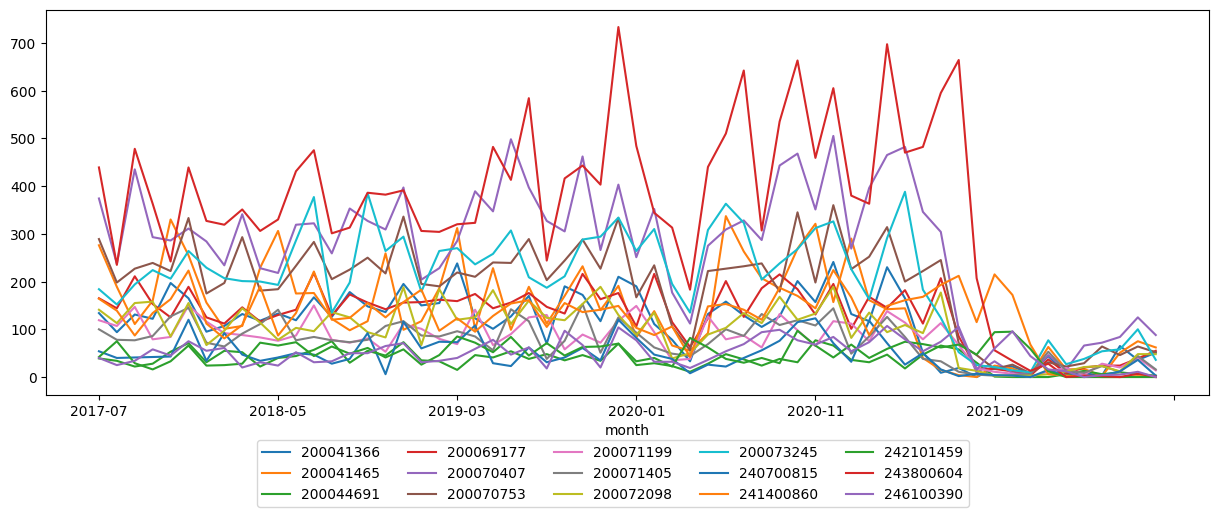

In [105]:
threshold = 0.26
restr = unstacked.loc[unstacked['nb_mutations_std/max']>threshold]
print(restr.index.to_list())
restr.drop('nb_mutations_std/max', axis=1).transpose().plot.line(figsize= (15,5)).legend(bbox_to_anchor=(0.8, -0.1), ncol=5)

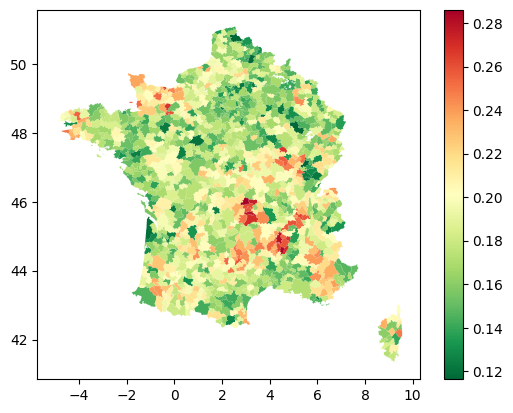

In [106]:
epci_gap = gpd.GeoDataFrame(pd.merge(unstacked.reset_index()[['code_epci','nb_mutations_std/max']].rename({'code_epci':'EPCI'}, axis=1),
                                         epci,
                                         on='EPCI',
                                         how='right'))
epci_gap.plot(column='nb_mutations_std/max', cmap='RdYlGn_r',
                  legend=True);

In [113]:
epci_years = unstacked.drop('nb_mutations_std/max', axis=1)
for y in range(2017, 2023):
    epci_years[str(y)] = epci_years[[c for c in epci_years if c.startswith(str(y))]].sum(axis=1)
    if not(y in [2017, 2022]):
        epci_years[str(y)] = epci_years[str(y)].apply(lambda x: round(x/2))
epci_years_restr = gpd.GeoDataFrame(pd.merge(epci_years.reset_index().rename({'code_epci': 'EPCI'}, axis=1)[['EPCI']+[str(y) for y in range(2017,2023)]],
                     epci,
                     on="EPCI",
                     how="right"))
epci_years_restr

,EPCI,2017,2018,2019,2020,2021,2022,geometry,nom
0,200000172,989.0,902.0,1006.0,960.0,990.0,313.0,"POLYGON ((6.44926 46.02174, 6.44924 46.02141, ...",VOUGY
1,200000438,916.0,962.0,1088.0,1095.0,1500.0,1399.0,"POLYGON ((-2.10656 47.38793, -2.10643 47.38765...",DREFFEAC
2,200000545,416.0,384.0,488.0,456.0,620.0,990.0,"POLYGON ((3.70070 48.47082, 3.70037 48.47103, ...",GELANNES
3,200000628,481.0,502.0,518.0,513.0,693.0,698.0,"POLYGON ((4.77496 44.23590, 4.77497 44.23591, ...",LAPALUD
4,200000800,390.0,370.0,516.0,470.0,438.0,897.0,"POLYGON ((2.08666 47.58654, 2.08617 47.58565, ...",LAMOTTE BEUVRON
...,...,...,...,...,...,...,...,...,...
1228,249500430,501.0,542.0,545.0,563.0,549.0,505.0,"POLYGON ((2.12013 49.06445, 2.12005 49.06444, ...",ARRONVILLE
1229,249500455,871.0,822.0,1082.0,890.0,997.0,873.0,"POLYGON ((2.16706 49.03191, 2.16670 49.03205, ...",BETHEMONT-LA-FORET
1230,249500489,677.0,580.0,888.0,854.0,944.0,815.0,"POLYGON ((2.30557 49.13253, 2.30544 49.13249, ...",BERNES-SUR-OISE
1231,249500513,448.0,506.0,492.0,538.0,553.0,602.0,"POLYGON ((1.73038 49.04966, 1.72893 49.04871, ...",AMBLEVILLE


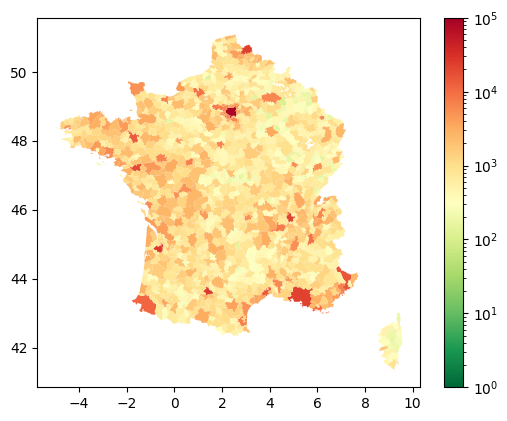

In [132]:
year = '2017'
epci_years_restr.plot(column=year, cmap='RdYlGn_r',legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5));

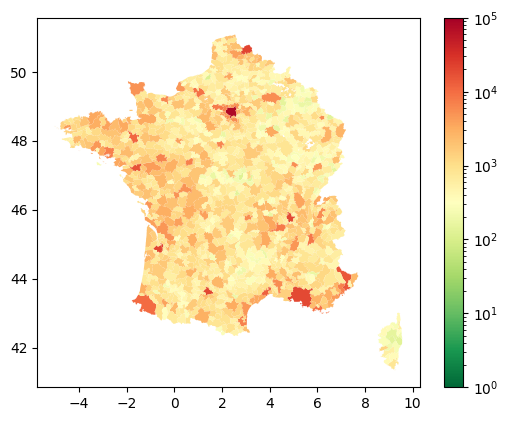

In [133]:
year = '2018'
epci_years_restr.plot(column=year, cmap='RdYlGn_r',legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5));

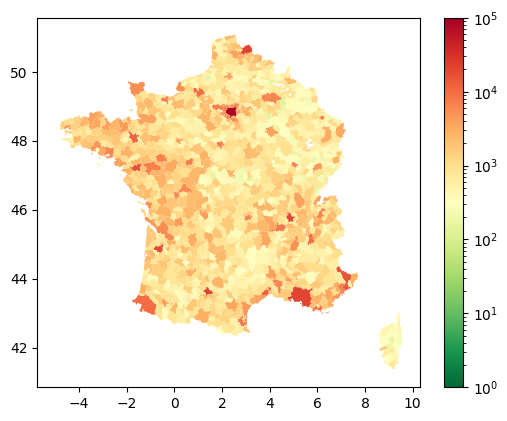

In [134]:
year = '2019'
epci_years_restr.plot(column=year, cmap='RdYlGn_r',legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5));

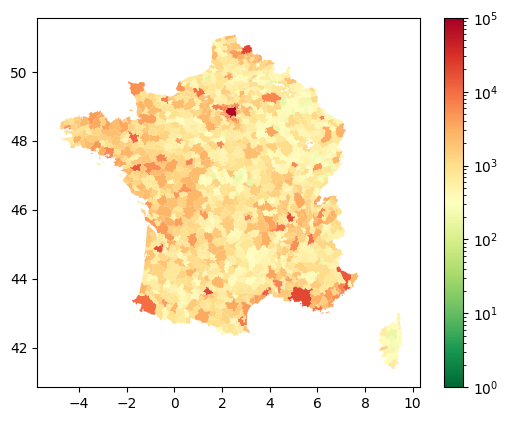

In [135]:
year = '2020'
epci_years_restr.plot(column=year, cmap='RdYlGn_r',legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5));

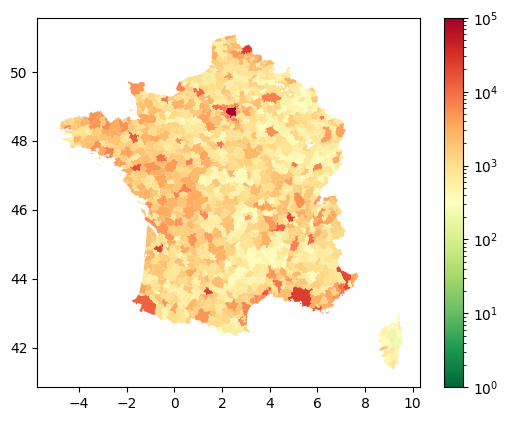

In [136]:
year = '2021'
epci_years_restr.plot(column=year, cmap='RdYlGn_r',legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5));

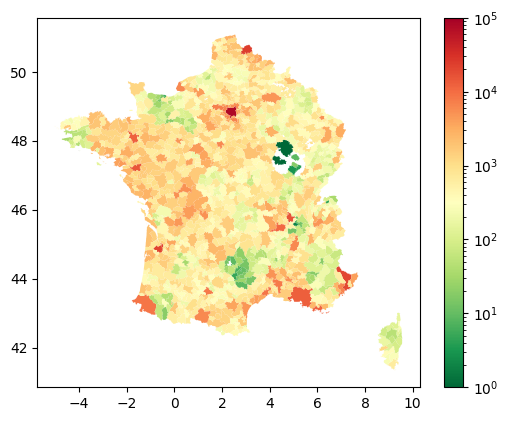

In [137]:
year = '2022'
epci_years_restr.plot(column=year, cmap='RdYlGn_r',legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5));

### EPCI en Côte d'or : pas de mutations dans certaines EPCI au S1 2022

In [37]:
## très peu de communes avec des mutations
df.loc[(df['code_commune'].str.startswith('21')) & (df['date_mutation']>'2022-01')]['code_commune'].value_counts()

21231    9
21278    5
21638    4
21692    4
21242    4
21442    3
21166    3
21054    2
21173    1
21640    1
21355    1
21317    1
21115    1
Name: code_commune, dtype: int64

In [36]:
def print_mutations_epci(dep, start_date='2022-01'):
    print('département '+dep)
    epci_dep = df_epci_month[df_epci_month['code_commune'].str.startswith(dep)]['code_epci'].dropna().unique()
    for e in epci_dep:
        print('nb mutations dans epci n°', e, ':', len(df.loc[(df['id_mutation'].isin(df_epci_month[df_epci_month['code_epci']==e]['id_mutation'])) & (df['date_mutation']>start_date)]))

In [40]:
## mutations par EPCI janvier-juin 2022
print_mutations_epci('21')

département 21
nb mutations dans epci n° 242100410 : 18
nb mutations dans epci n° 200039055 : 0
nb mutations dans epci n° 200070894 : 3
nb mutations dans epci n° 200070902 : 0
nb mutations dans epci n° 200000925 : 4
nb mutations dans epci n° 200039063 : 0
nb mutations dans epci n° 200069540 : 0
nb mutations dans epci n° 200071207 : 0
nb mutations dans epci n° 242101434 : 1
nb mutations dans epci n° 200006682 : 91
nb mutations dans epci n° 242100154 : 9
nb mutations dans epci n° 200072825 : 0
nb mutations dans epci n° 200070910 : 0
nb mutations dans epci n° 242101491 : 0
nb mutations dans epci n° 242101459 : 0
nb mutations dans epci n° 242101509 : 0
nb mutations dans epci n° 200071173 : 0
nb mutations dans epci n° 200071017 : 1
nb mutations dans epci n° 242101442 : 0


In [39]:
## la Creuse pour comparaison
print_mutations_epci('23')

département 23
nb mutations dans epci n° 200067544 : 541
nb mutations dans epci n° 200067189 : 949
nb mutations dans epci n° 242300135 : 292
nb mutations dans epci n° 200034825 : 626
nb mutations dans epci n° 200041556 : 277
nb mutations dans epci n° 242320000 : 433
nb mutations dans epci n° 242320109 : 510
nb mutations dans epci n° 200066744 : 1548
nb mutations dans epci n° 200044014 : 690
nb mutations dans epci n° 200067593 : 473
